## Fraud Detection in Credit Card Transactions using ML Techniques

### Introduction
The objective in this project is to build machine learning models to classify or identify fraudulent card transactions from a given card transactions data.  

### Data Description

The [dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud/data) contains two-days credit card transactions made in September 2013 by European cardholders. The dataset is highly unbalanced with a low percentage of fraudulent transactions within several records of normal transactions. The positive class (frauds) account for 0.172% (492 frauds out of 284,807 transactions) of all transactions.

Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset.  Feature 'Class' is the target variable with value 1 in case of fraud and 0 otherwise. 

### Import Libraries

In [6]:
# Import basic libraries 
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import ADASYN 
from collections import Counter
import seaborn as sn

# plot functions
#import plot_functions as pf

# scikit packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn import metrics

# settings
%matplotlib inline
sn.set_style("dark")
sn.set_palette("colorblind")

### Load Data  
The dataset used in this project is freely available at: https://www.kaggle.com/mlg-ulb/creditcardfraud/data

In [7]:
df = pd.read_csv("creditcard.csv")

In [8]:
# View top 5 records
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# determine the number of records in the dataset
print('The dataset contains {0} rows and {1} columns.'.format(df.shape[0], df.shape[1]))

The dataset contains 284807 rows and 31 columns.


In [10]:
# check for missing values and data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Explore label class

In [11]:
print('Normal transactions count: ', df['Class'].value_counts().values[0])
print('Fraudulent transactions count: ', df['Class'].value_counts().values[1])

Normal transactions count:  284315
Fraudulent transactions count:  492


### Separate feature data (predictors) from labels

In [12]:
# feature data (predictors)
X = df.iloc[:, :-1]

# label class
y = df['Class']

### Standardize data
Scale the data to have zero mean and unit variance.

In [13]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

### Partition data into train and test sets

In [14]:
# Partition data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state = 42)

### Data Sampling  
- We previously saw that the dataset is imbalanced. 
- Training such an imbalanced dataset with ML algorithms may lead to misclassification of minority class. 
- Therefore, to compensate for the imbalance, we will use ADASYN oversampling method as implemented in imbalanced-learn  package to resample the dataset. 

- ADASYN (ADAptive SYNthetic) is an oversampling technique that adaptively generates minority data samples using K nearest neighbor.

In [15]:
# Apply the ADASYN over-sampling
ada = ADASYN(random_state = 42)
print('Original dataset shape {}'.format(Counter(y_train)))
X_res, y_res = ada.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 190477, 1: 343})
Resampled dataset shape Counter({0: 190477, 1: 190471})


### Train Models  
Three machine learning algorithms: Logistic Regression, Naive Baye, and RandomForest classifiers were trained using the processed feature data.

In [16]:
X_train, y_train = X_res, y_res 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression()
LGR_Classifier.fit(X_train, y_train)

# Train Random Forest Model
RDF_Classifier = RandomForestClassifier(random_state=0)
RDF_Classifier.fit(X_train, y_train)

# Train Bernoulli Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train)

### Evaluate Models  

In [17]:
# Evaluate models
modlist = [('RandomForest Classifier', RDF_Classifier),('LogisticRegression', LGR_Classifier),
('Naive Baiye Classifier', BNB_Classifier)] 

models = [j for j in modlist]

print()
print('========================== Model Evaluation Results ========================' "\n")  

for i, v in models:
    scores = cross_val_score(v, X_train, y_train, cv = 10) # we will use 10 folds
    accuracy = metrics.accuracy_score(y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(y_train, v.predict(X_train))
    classification = metrics.classification_report(y_train, v.predict(X_train))
    print('===== {} ====='.format(i))
    print()
    print ("Cross Validation Mean Score: ", '{}%'.format(np.round(scores.mean(), 3) * 100))  
    print() 
    print ("Model Accuracy: ", '{}%'.format(np.round(accuracy, 3) * 100)) 
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()
    print("Classification Report:" "\n", classification) 
    print()


========================== Model Evaluation Results ========================

===== RandomForest Classifier =====

Cross Validation Mean Score:  93.0%

Model Accuracy:  100.0%

Confusion Matrix:
 [[190477      0]
 [     0 190471]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    190477
           1       1.00      1.00      1.00    190471

    accuracy                           1.00    380948
   macro avg       1.00      1.00      1.00    380948
weighted avg       1.00      1.00      1.00    380948


===== LogisticRegression =====

Cross Validation Mean Score:  87.4%

Model Accuracy:  90.10000000000001%

Confusion Matrix:
 [[174116  16361]
 [ 21442 169029]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90    190477
           1       0.91      0.89      0.90    190471

    accuracy                           0.90    380948
   macro avg

### Plot Functions 

In [38]:


import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

def plot_confusion_matrix(cm, classes, title, cmap):
    "function for plotting confusion matrix"
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    classnames = classes
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classnames))
    plt.xticks(tick_marks, classnames, rotation=45)
    plt.yticks(tick_marks, classnames)
    s = [['TN','FP'], ['FN', 'TP']]
 
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()


def plot_roc_auc(arg1, arg2, arg3):
    "a function to plot roc_auc"
    fig, ax = plt.subplots(figsize=(8, 6))
    for i, v in arg1: 
        y_score = v.predict_proba(arg2)[:, 1]
        fpr, tpr, _ = metrics.roc_curve(arg3, y_score) 
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,lw=2, label= i + ' (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()  

### Test Models


========================== Model Test Results ========================



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


=== RandomForest Classifier ===
Model Accuracy:  100.0%

Confusion Matrix:
 [[93819    19]
 [   25   124]]



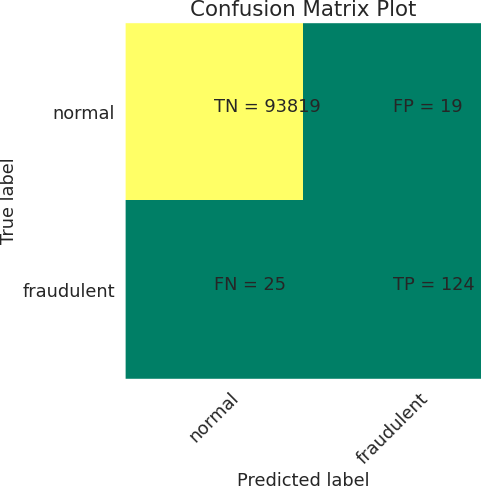


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     93838
           1       0.87      0.83      0.85       149

    accuracy                           1.00     93987
   macro avg       0.93      0.92      0.92     93987
weighted avg       1.00      1.00      1.00     93987


=== LogisticRegression ===
Model Accuracy:  91.2%

Confusion Matrix:
 [[85614  8224]
 [    7   142]]



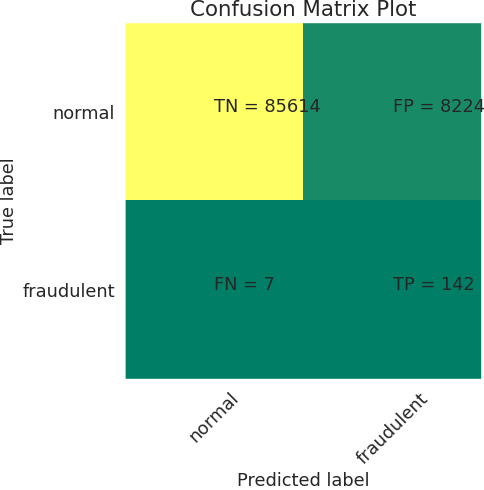


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.95     93838
           1       0.02      0.95      0.03       149

    accuracy                           0.91     93987
   macro avg       0.51      0.93      0.49     93987
weighted avg       1.00      0.91      0.95     93987


=== Naive Baiye Classifier ===
Model Accuracy:  89.4%

Confusion Matrix:
 [[83873  9965]
 [   10   139]]



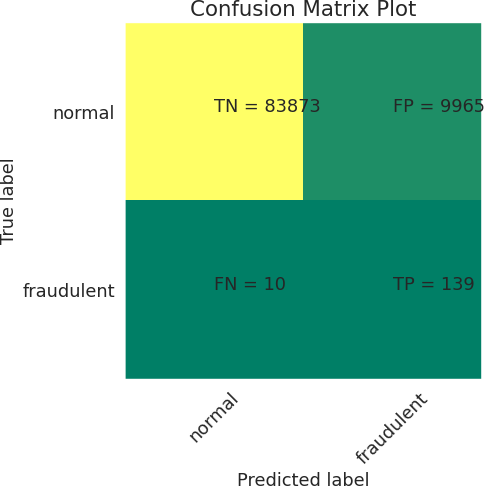


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     93838
           1       0.01      0.93      0.03       149

    accuracy                           0.89     93987
   macro avg       0.51      0.91      0.49     93987
weighted avg       1.00      0.89      0.94     93987


============================= ROC Curve ===============================



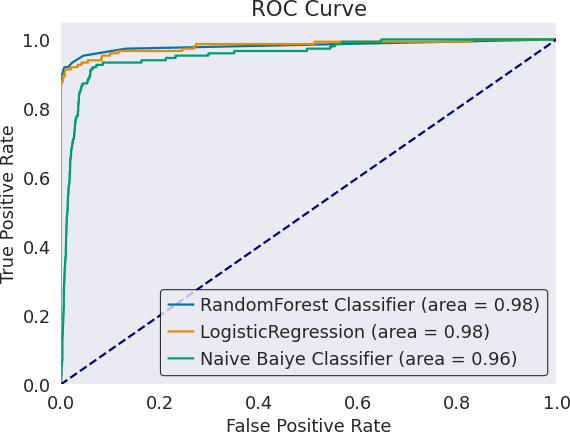

In [40]:
# Test models
classdict = {'normal':0, 'fraudulent':1}
print()
print('========================== Model Test Results ========================' "\n")   

for i, v in models:
    accuracy = metrics.accuracy_score(y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(y_test, v.predict(X_test))
    classification = metrics.classification_report(y_test, v.predict(X_test))   
    print('=== {} ==='.format(i))
    print ("Model Accuracy: ",  '{}%'.format(np.round(accuracy, 3) * 100))
    print()
    print("Confusion Matrix:" "\n", confusion_matrix)
    print()
    plot_confusion_matrix(confusion_matrix, classes = list(classdict.keys()), title='Confusion Matrix Plot', cmap=plt.cm.summer)
    print() 
    print("Classification Report:" "\n", classification) 
    print() 

print('============================= ROC Curve ===============================' "\n")      
plot_roc_auc(arg1=models, arg2=X_test, arg3=y_test)